# Introduction

The Barmose I dataset, a well-known Early Mesolithic site in Denmark, has become a benchmark for evaluating spatial clustering methods in archaeology. This dataset includes the spatial distributions of artifacts, interpreted as representing distinct activity areas within the site. It was first systematically analyzed in the early 1990s as part of a study comparing clustering algorithms to assess their ability to detect these spatial patterns based solely on artifact positions. In 2016, [Ducke](https://www.taylorfrancis.com/chapters/edit/10.1201/b18530-21/spatial-cluster-detection-archaeology-current-theory-practice-benjamin-ducke) revisited the case study, updating the methodological comparison and reframing the exercise as the "Barmose challenge," posing the key question:

*Can clustering methods identify meaningful spatial structures in artifact distributions using minimal assumptions?*

Ducke tested modern clustering algorithms, including DBSCAN and Expectation Maximization (Gaussian Mixture Models), ultimately concluding that DBSCAN performed best. His reasoning was that DBSCAN produced results closely aligned with archaeological expectations for the number and location of activity areas at the site. More importantly, Ducke explicitly outlined several traits he believed made a clustering approach or algorithm useful for archaeology:

1. The method’s mathematical basis should be simple enough for archaeologists to understand;
2. it should make minimal assumptions about the number, size, and location of clusters;
3. it should "... be robust against noise, i.e., it should just ignore the odd scattering of sherds around the actual clusters, and it should not assume that every point is indeed part of a cluster";
4. it should make definitive assignments about cluster membership (or label a point not belonging to a cluster as noise); and
5. it should produce replicable results given the same dataset as input.

While these criteria may be reasonable enough (depending on how we define benchmarks for the mathematical competence of archaeologists and whether one adopts a probabilistic perspective on process), Ducke’s presentation reveals an additional, implicit criterion: *a useful method should produce clusters that align with archaeological understanding of site structure*. In other words, the method should confirm preconceived notions about the point-process underlying artifact distributions.

This implicit criterion is evident in Ducke’s description of Blankholm’s original methodological study:

    "Based on these remains, Blankholm formulated an archaeological expectation of the site’s cluster structure and then proceeded to test how well this structure was revealed by the different methods."

Ducke adopts a similar approach, ultimately preferring DBSCAN because it aligns well with these expectations. For instance, he criticizes the k-means method for:

    "... the complete partitioning that also includes scattered points which should rather be classified as noise and does not represent a good approximation of the actual cluster shapes."

This critique implies prior knowledge of both cluster shapes and the definition of noise, concepts that clustering methods are ostensibly meant to uncover. Similarly, Ducke assesses Expectation Maximization (EM, described as a Gaussian Mixture Model) by conceding that its output might be valid if one:

    "... disregards any a priori expectations of the site’s structure."

Once again, the benchmark for success appears to be the extent to which a method reproduces what archaeologists already "know" about site structure and which clusters are "real" reflections of the processes that produced them.

Ultimately, Ducke’s preference for DBSCAN is shaped not only by its deterministic orientation and robustness but also by its ability to align with prior expectations about the site. In doing so, he declares it the winning method of the "Barmose Challenge."

Continuing the challenge, we revisit the Barmose I dataset using the `chronocluster` package. While these data lack chronological depth—limiting our ability to showcase the full potential of spacetime point pattern analysis and methods for handling chronological uncertainty (the package’s key strengths)—they provide an excellent opportunity to demonstrate the structured, systematic, and probabilistic paradigm that chronocluster offers. This approach allows us to explore clustering in a way that is transparent, reproducible, and free from the pitfalls of relying solely on preconceived expectations.

# Barmose Callenge with chronocluster
The objective here is straightfoward: to compare the `chronocluster` package toolchain with results from other methods presented in the literature using the data from Barmose I as a nice basis for comparison.

## Libraries
We will load a number of libraries, inclusing general Python datascience packages, vizualization packages, and chronocluster methods. Note, though, that we are using another new (small) package called [archdatapy](https://github.com/wccarleton/archdatapy). This package is able to grab the [archdata](https://cran.r-project.org/web/packages/archdata/index.html) package data from CRAN, which contains datasets used in [Quantitative Methods in Archaeology Using R](https://doi.org/10.1017/9781139628730) by David L Carlson, one of the Cambridge Manuals in Archaeology.

In [1]:
# Analysis, General
import numpy as np

# Chronocluster Analytics
from chronocluster import clustering
from chronocluster.data.dataio import df_to_pts
from chronocluster.density import kde_time, custom_kde, kde_peaks, pymc_gmm_peak_finder, rank_peaks
from chronocluster.clustering import bise

# Data
from archdatapy import get_archdata, load_archdata

# plotting
import matplotlib.pyplot as plt
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, get_box, chrono_plot, draw_ellipses

## Data
Now, get the data from `archdata` using `archdatapy`. First, we grab the available data, download it to a temporary directory, and store the dataset names and associated paths in a dictionary. This dictionary can then be printed to view the available datasets.

In [2]:
# Download datasets and get the file paths
file_paths = get_archdata()
print("Available datasets and their file paths:")
for dataset_name, path in file_paths.items():
    print(f"{dataset_name}: {path}")

Available datasets and their file paths:
Acheulean: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\Acheulean.rda
Arnhofen: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\Arnhofen.rda
BACups: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\BACups.rda
BarmoseI.grid: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\BarmoseI.grid.rda
BarmoseI.pp: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\BarmoseI.pp.rda
Bornholm: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\Bornholm.rda
DartPoints: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\DartPoints.rda
EIAGraves: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\EIAGraves.rda
EndScrapers: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\EndScrapers.rda
EngrBone: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\EngrBone.rda
ESASites: C:\Users\carleton\AppData\Local\Temp\tmpfae__k_s\archdata/data\

Next, we isolate the Barmose I point data.

In [3]:
# Choose a dataset to load
dataset_name = 'BarmoseI.pp'
data = load_archdata(file_paths[dataset_name])

# Inspect the loaded data
print(f"Contents of the dataset '{dataset_name}':")
for obj_name, obj_value in data.items():
    print(f"Object name: {obj_name}, Object type: {type(obj_value)}")

Contents of the dataset 'BarmoseI.pp':
Object name: BarmoseI.pp, Object type: <class 'pandas.core.frame.DataFrame'>


We then have to put this point data into a Pandas dataframe in a format that we can easily transform into a list of `Point` objects from the `chronocluster` package. This dataframe needs to have variables with the following names in order for `chronoclusters` i/o utilities to be useful:

- `x` (x-coordinate)
- `y` (y-coordinate)
- `start_type` (distribution type for the start date distribution)
- `end_type` (distribution type for the end date distribution)
- `start_params` (parameters required for the `start_type` distribution)
- `end_params` (parameters required for the `end_type` distribution)

Since the data come with no explicit chronological information, we will just use the same fixed (`ddelta`) distribution for all start/end dates, We can use the roughly defined easliest occupation of the Barmose I phase (~10,950 BP) as the start date and end of the phase (~7950 BP) as the end date. To keep plotting simple and avoid mixups owing to inverted axes, we will use negative date values to indicate BP (1950).

In [4]:
# Step 1: Rename 'north' to 'y' and 'east' to 'x'
df = data[dataset_name]  # Load your DataFrame
df = df.rename(columns={'North': 'y', 'East': 'x'})

# Step 2: Add constant date parameters in negative BP
df['start_type'] = 'constant'
df['start_params'] = [(-10950,)] * len(df)  # Start date at -10950 BP (9000 BCE)
df['end_type'] = 'constant'
df['end_params'] = [(-7950,)] * len(df)     # End date at -7950 BP (6000 BCE)

# Have a look at the constructed dataframe with the Barmose I data pulled in
df.iloc[0:4,:]

,y,x,Class,Label,start_type,start_params,end_type,end_params
0,5.50,3.75,1,Scrapers,constant,"(-10950,)",constant,"(-7950,)"
1,7.92,1.35,1,Scrapers,constant,"(-10950,)",constant,"(-7950,)"
2,10.50,1.92,1,Scrapers,constant,"(-10950,)",constant,"(-7950,)"
3,8.50,2.42,1,Scrapers,constant,"(-10950,)",constant,"(-7950,)"


Next, convert the dataframe to a list of `Point` objects:

In [5]:
# Step 3: Convert to Points
points = df_to_pts(df)

# Verify output
points[0:4]  # Display the first 5 Points objects to verify

[Point(x=3.75, y=5.5, start_distribution=ddelta(d=-10950), end_distribution=ddelta(d=-7950)),
 Point(x=1.35, y=7.92, start_distribution=ddelta(d=-10950), end_distribution=ddelta(d=-7950)),
 Point(x=1.92, y=10.5, start_distribution=ddelta(d=-10950), end_distribution=ddelta(d=-7950)),
 Point(x=2.42, y=8.5, start_distribution=ddelta(d=-10950), end_distribution=ddelta(d=-7950))]

And, we can plot them in a spacetime volume---though, there is no meaningful pattern in the chronological dimension, in this case.

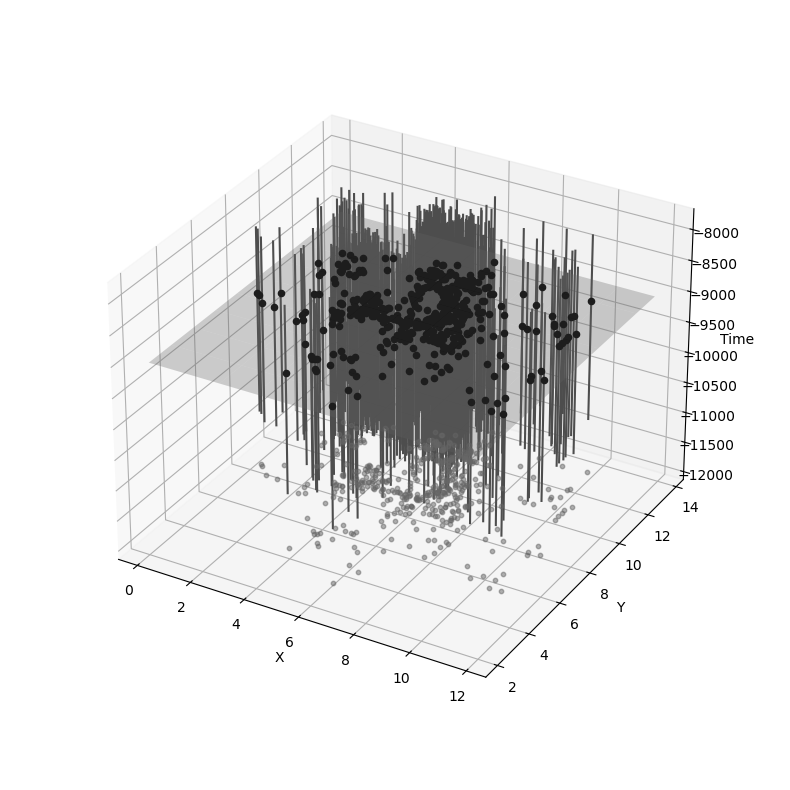

In [6]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax,_ = chrono_plot(points, style_params=style_params, time_slice=-9000)
ax.set_box_aspect(None, zoom=0.85)

## Characteristic Scale(s)

For the rest of the analysis, just select a valid time slice and continue following the `chronocluster` workflow (described in the package tutorial) to produce a pairwise distance density (pdd) surface. The pdd can be used to identify the characteristic scales of the point pattern. 

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Mean Pairwise Distances(d) Function Over Time and Distance'}, xlabel='Time Slices', ylabel='Distances'>)

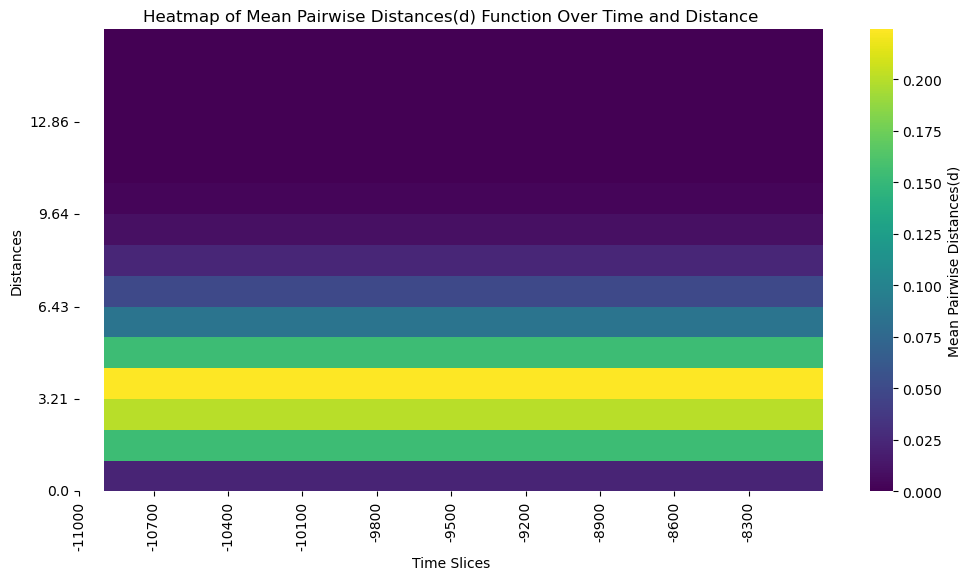

In [13]:
# Define the time slices
start_time = -11000
end_time = -8000
time_interval = 100
time_slices = np.arange(start_time, end_time, time_interval)

# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 10
simulations = clustering.mc_samples(points, 
                                    time_slices, 
                                    num_iterations=num_iterations)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# standard bw
use_kde = True
pair_bw = 1
if use_kde:
    pair_bw = 0.5 * pair_bw
    kde_samples_n = 15

# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices, 
                                                         bw=pair_bw, 
                                                         use_kde=use_kde,
                                                         kde_sample_n=kde_samples_n,
                                                         max_distance=max_distance)

# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

### Baseline-Informed Spatial Expectation (BISE)

As several authors have indicated (including Ducke), the null-model used to identify significant structure in point patterns can vary. Sometimes it makes sense to use Complete Spatial Randomness (CSR), while at other times it makes more sense to produce a null that reflects our knowledge and questions about the specific pattern in question (i.e., an expectation informed somehow by a scientifically meaningful baseline). The baseline might be a model that controls for certain geographic or ecological traits (e.g., rivers, land-cover) or one that accounts for a pattern we expect to see but aren't interested in. Below, we use a `chronocluster` approach that reflects the expectation that anthropogenic point patterns will tend to,

1. have multi-scale clustering, and
2. large-scale densities that reflect overall 'gravity' like effects (overall clustering within a given study area).

With that general BISE, we can then estimate the probability that the obeserved point pattern contains ppd modes that differ significantly from it. These will be the BISE characteristic scales of the point pattern.


(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Probability Heat Map'}, xlabel='Time Slices', ylabel='Pairwise Distances'>)

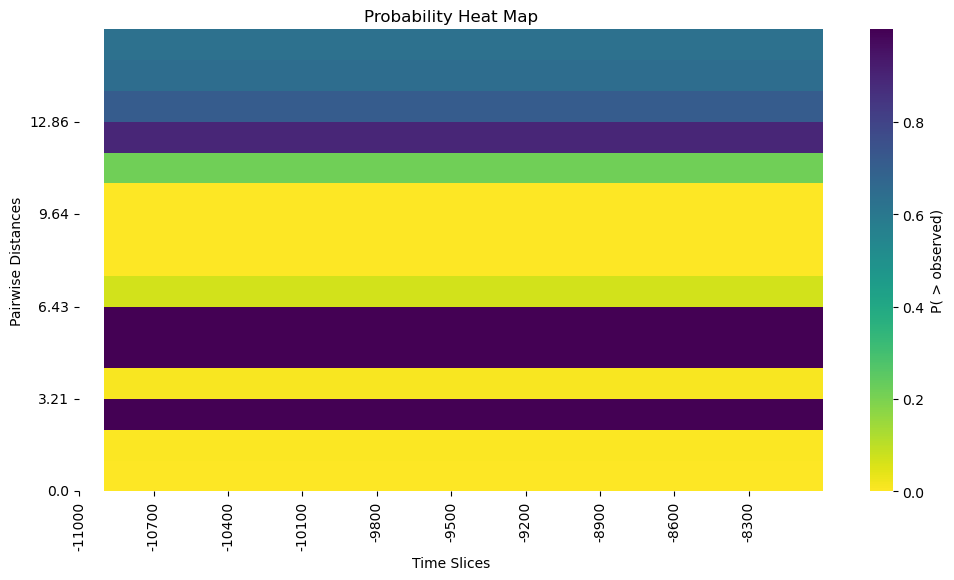

In [14]:
# Generate BISE sample
# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(points, 
                                         time_slices=time_slices,
                                         num_iterations=num_iterations,
                                         null_model=bise)

# Calulate the pairwise distances for the BISE sample
bise_pairwise_density, bise_support = clustering.temporal_pairwise(bise_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde, 
                                                                 kde_sample_n=kde_samples_n,
                                                                 max_distance = max_distance)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, bise_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              bise_support)

The pdd significance plot indicates at least three potentially significant characteristic scales. This is a good demonstration of how using the BISE reveals structure that was originally swamped out by the strength of the significant scale identified in the raw pdd surface. That original bright mode corresponded to a distance of around 3.5, which corresponds to roughly a standard deviation of the overall point cloud (if we imagine a single normal density used to describe the broad shape and size of the totality of the points). Something close to that scale still comes through in the significance plot above, but others are now apparent as well. In particular, we can see a mode at about 1.0m, which is highly relevant archaeologically in this case since these points represent activity around a small hearth.

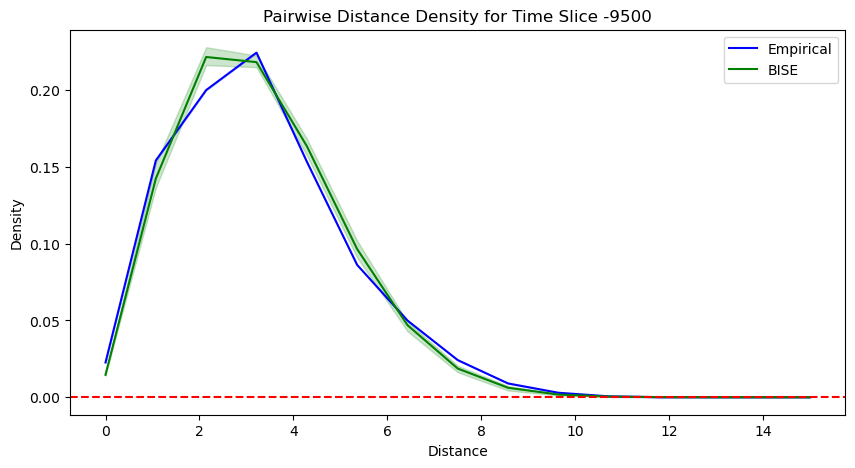

In [15]:
from chronocluster.utils import plot_pdd

time_slice_idx = np.where(time_slices == -9500)[0][0]  # corresponding to time 1100

# List of density arrays
density_arrays = [pairwise_density, bise_pairwise_density]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical", "BISE"],
    colors=["blue", "green"]
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Show the plot
plt.show()

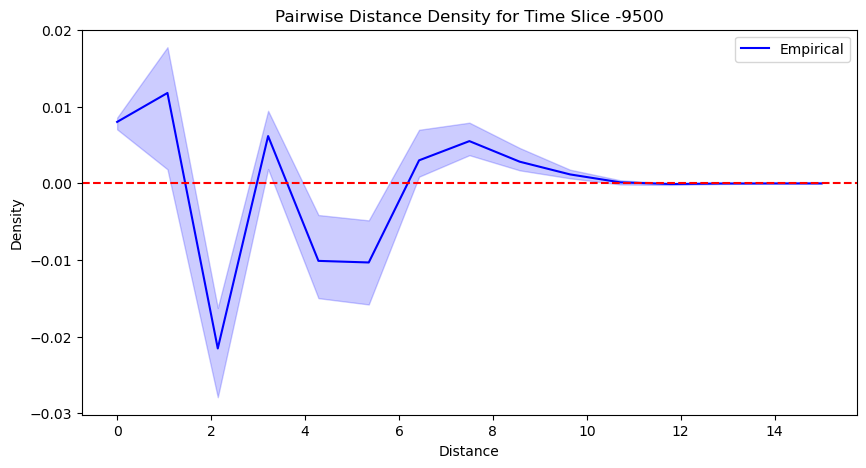

In [16]:
# List of density arrays
density_arrays = [diff_array]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical"],
    colors=["blue", "green"]
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Show the plot
plt.show()

In [17]:
# identify approximate characteristic scales
characteristic_scales = [1.0, 7.0]

## Kernel Density Estimation (KDE)

Now we can use one of the identified characteristic scales to produce a KDE surface. It's worth remembering that the KDE tool in `chronocluster` folds in chronological trends and patterns by weighing the density by probability that each point exists in the relevant time-slice even though, in this case, we aren't really dealing with chronological data. If dates were available for the individual points in the pattern, though, we could have included that data and then conducted a spacetime clustering analyis.

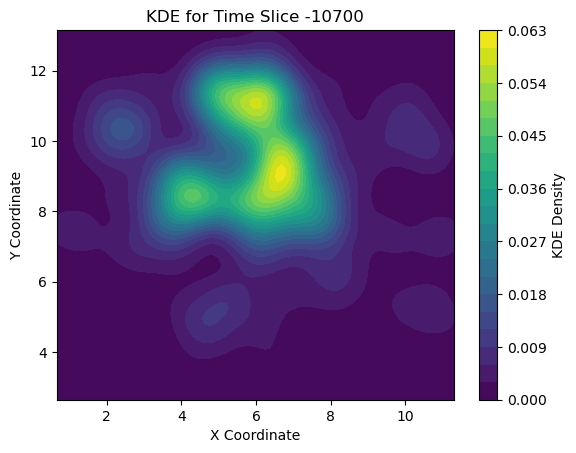

In [18]:
# define a grid and relevant parameters for estimating the KDE
grid_resolution = 100
x_grid = np.linspace(x_min, x_max, grid_resolution)
y_grid = np.linspace(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
grid = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T 

# Set parameters for KDE
time_slice = time_slices[3]
bandwidth = characteristic_scales[0] * 0.5 # from the pairwise distance density

# Calculate KDE for the chosen time slice and one of the characteristic scales
kde_values = kde_time(points, 
                      time_slice, 
                      bandwidth, 
                      grid, 
                      output_shape=x_mesh.shape, 
                      kde_method=custom_kde)

# Plotting
plt.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')
plt.colorbar(label="KDE Density")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"KDE for Time Slice {time_slice}")
plt.show()

The KDE surface looks very much like the one presented in Ducke 2016. There is a near ring of clumpy, higher density around a central area that corresponds to the hearth idensitifed at the site.

## Bayesian Gaussian Mixture Model for Peak Identification

Next, we will use the Bayesian Gaussian Mixture Model provided by `chronocluster` (i.e., the `pymc_gmm_peak_finder` peak finding tool). This model identifies clusters (or peaks) in spatial data by fitting a probabilistic mixture of Gaussian components. Unlike deterministic methods, the Bayesian GMM approach provides posterior distributions for key parameters---such as component weights, means, and covariances---allowing for uncertainty quantification and more robust peak identification along with the inclusion of chronological patterns and uncertainty. The model leverages prior information (the chosen characteristic scale of the analysis) and suppresses superfluous components, ensuring that only meaningful clusters (at the given scale) are highlighted. This makes it particularly well-suited for complex datasets, where noise or overlapping clusters might otherwise obscure significant spatial structures. 

It's important to note that the number of `max_components` specifies only the the number of components included in the model, not the number that will ultimately identified as significant---the number of significant peaks will always be equal to or less than `max_components`. Max components, $ k $, is then used to define the weight threshold for surfacing important thresholds in the following way,

$ w_k - \frac{1}{k} $,

where $ w_k $ is the GMM weight for the $ k^{th} $ component. This threshold relies on the built-in property of GMM models that they estimate the weights of the components based on how many of the observations are accounted for by the relevant component. Thus, components that aren't required to account for the observed data are down-weighted. The threshold itself, $ \frac{1}{k} $, implies an expectation that components are all equally weighted and account equally for the available data. So, the difference between this expectation and the actual estimated weights can be used to highlight peaks that account for more than an equal share of the data while at the same time de-emphasing peaks that account for less.

Additionally, it is important to understand that the target_scale is defined as,

$\xi_{target} = \frac{1}{2}\xi$.

This definition is used because we are interested in finding cluster centers, which are akin to centres of gravity for all the points. The characteristic scale identified in the pdd, though, refers to point-wise distances. If we were considering only two points, we would set the bandwidth of a KDE or other cluster-seeking tool to half the inter-point distance in order to identify the mid-point, or gravitational centre of the points. The same logic extends to many points when we consider the modes of the pdd. So, we use half the characteristic scale as the prior for the mean of the component standard-deviations and we include another parameter, `target_scale_sd`, that determines the variance of that prior. Teh variance reflects the fact that we are uncertain about the real characteristic scale of the process that produced the observations (and it may in fact be variable anyway).

Lastly, it's also useful to explain that we set a prior for the means of the components (the x,y coordinate locations of cluster centres) with a bounding box that minimally constrains the observed data. Another prior could be used and, as long as it enveloped all of the data, the same answers would ulimately be obtained. But, using a much wider bounding box would allow the Bayesian algorithm---Metropolis Hastings Markov-Chain Monte Carlo (MH-MCMC), or No-U-turn Sampler (NUTS)---to explore a lof of unnecessary parameter space (i.e., places outside the observed data where no cluster means are going to be anyway).

With all this in mind, we run the Bayesian GMM cluster finding anlaysis as follows:

In [19]:
# Calculate the spatial extent based on bounding box to constrain the prior for
# the component means (parameter space outside this area is going to be fruitless)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))
bounding_box_variance = ( max_distance/ 2)**2

# Set maximum number of components to allow in the model
max_components = 7
w_threshold = 1 / max_components # used for idenitifying peak importance

# Priors for spatial scale (variance) based on pairwise distance density analysis
target_scale = characteristic_scales[0] * 0.5 # This is our target spatial scale for each component
target_scale_sd = 0.01  # Some variation around this value

# time slice (set earlier on, but to jog the memory)
time_slice = time_slices[3]

# Run kde_peaks with GMM as the peak-finding method
# Assuming coordinates is your dataset of temple locations, passed as Point objects
peaks, weights, trace = kde_peaks(points=points, 
                                    num_peaks = max_components, 
                                    peak_finder = pymc_gmm_peak_finder,
                                    time_slice = time_slice,
                                    target_scale = target_scale,
                                    target_scale_sd = target_scale_sd,
                                    w_threshold = w_threshold,
                                    sampler = 'NUTS',
                                    draws = 2000,
                                    tune = 4000,
                                    chains = 1)

Sequential sampling (1 chains in 1 job)
NUTS: [w, means, chol_0, chol_1, chol_2, chol_3, chol_4, chol_5, chol_6]


c:\Users\carleton\AppData\Local\miniconda3\envs\pybayes\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 4_000 tune and 2_000 draw iterations (4_000 + 2_000 draws total) took 311 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Significant Peaks
As explained, we use the estimated component weights to identify the important peaks. The `rank_peaks` function in `chronocluster` performs the task in one of two ways: 

1. using `source_param = 'importance'`, defined as the difference between the estimated weight of a component and the baseline; or
2. cumulatively summing the raw (mean) weight estimates.

The first of these two approaches invovled using the Highest Density Interval (hdi) of the posterior density of the importance variable for a given component. The importance vairable is calculated internally during the MCMC for the Bayesian model and, so, we can simply assess the posterior. Using an hdi of 0.80 implies that 90% of the posterior should be greater than zero (because this is effectively a one-sided test where we are comparing the posterior density only to zero). Components with peaks that pass this test would be considered important.

The alternative method, `source_param = 'w'` (meaning 'weights'), produces a dataframe containing the raw estimated (mean) weights for each component. These can then be summed cumulatively to identify important peaks in much the same way that analysts use the cumulative sum of variance accoutned for to identify important principle components in a Principle Component Analysis. Since the weights directly reflect the number of observations 'accounted for' (in a likelihood sense) by each GMM component, ordering the components be weight (descending) and performing the cumulative sum is effectively indicating the increasing proportion of observations accounted for by including each component, starting with the one that accounts individually for the largest proportion of the data and progressively including each less important peak. See the package tutorial for more details and an example. These approaches can be expected to normally give the smae indication about peak importance, especially as `max_components` increases (because using several more peaks than are likely actually necessary improves GMM peak finder and, in particular, the efficiency of the benchmark method).  

In [20]:
# esatblish a baseline for significant deviations in the weights from the threshold
# this baseline implies 90% of the posterior density is > 0
importance_hdi = 0.80
summary_df = rank_peaks(trace, significance=importance_hdi, source_param='importance')

# isolate important peaks
# Filter rows where the lower bound of the HDI is greater than importance_threshold
importance_threshold = 0
condition = summary_df[f'{int(importance_hdi * 100)}% HDI (Importance)'].apply(lambda hdi: hdi[0] > importance_threshold)
important_peaks = summary_df[condition] # isloated for plotting below
summary_df

,Rank,Importance,Coordinates,Covariances,80% HDI (Importance)
0,1,0.133618,"(5.587703229896132, 11.109884489258741)","[[0.3026558601642477, -0.024722468651651317], ...","(0.111044010427236, 0.14950190624596232)"
1,2,0.113458,"(6.423300590295315, 8.97465037075615)","[[0.2864095775932205, 0.1428007058349152], [0....","(0.09134155296348676, 0.13150006911384177)"
2,3,0.068978,"(3.477705258872909, 8.693847885195831)","[[0.33969354798000845, -0.04475755005174224], ...","(0.05196948733549828, 0.0848233135083733)"
3,4,-0.011506,"(7.068640321899034, 7.680760932028451)","[[0.26778519678543083, 0.0940927396444987], [0...","(-0.026974437799906534, 0.0042366929898819405)"
4,5,-0.094551,"(9.66927100525568, 6.100702599343019)","[[0.2796874450879474, -0.03137258090672954], [...","(-0.10375414091885551, -0.08623983868787935)"
5,6,-0.101942,"(9.877381335080418, 10.802377167775798)","[[0.255896467843989, -0.0780235044358465], [-0...","(-0.11004157738096151, -0.09437769649257133)"
6,7,-0.108055,"(5.4271285951099, 4.964358654253993)","[[0.2653356590973647, -0.04693490598681378], [...","(-0.11701755345782858, -0.10107609214268759)"


### Plotting
At last, plot the data and examine the identified peaks relative to the KDE (all, of course, given the target charactersitic scale). Visually, the 'important' peaks identified by this analysis correpsond pretty well in location and shape with the brightest parts of the KDE. These results differ substantially from the 'Expectation Maximization' results presented by Ducke (2016) and appear to satisfyingly capture the density at the given characteristic scale. There are 4 additional peaks that could be plotted, all of which account for some amount of the data, but Ducke specified that a useful cluster identification tool should somehow flag or exclude 'noise'. It we define noise using the importance threshold or cumulative sum of raw weights, then the three idenfitied peaks here account for the vast majority of the observed points in the total scatter (plotted below are only the first two standard deviations of each component, which means they 'cover' more of the data than indicated). The 'noise' then are the points that are less densely scattered around these three main peaks. Of course, these defintions are somewhat arbitrary, but Ducke was not explicit enough about what 'noise' means to be any more concrete.

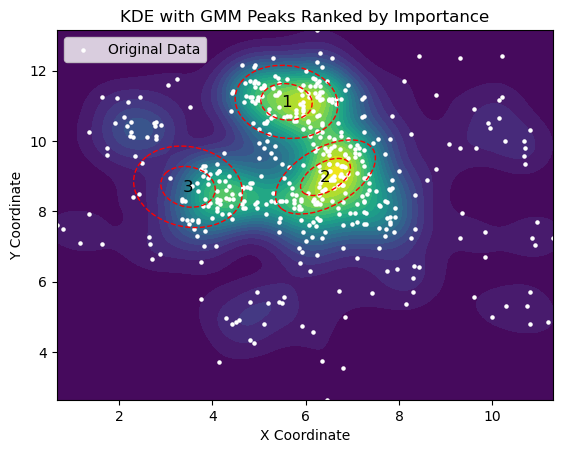

In [21]:
# Plotting
fig, ax = plt.subplots()

# Plot KDE density surface
ax.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')

# Extract the X and Y coordinates from the Coordinates column for plotting
x_coords = important_peaks['Coordinates'].apply(lambda coord: coord[0])
y_coords = important_peaks['Coordinates'].apply(lambda coord: coord[1])

# Plot the original data points
ax.scatter(df['x'], df['y'], color='white', marker='o', s=5, label='Original Data')

# Draw ellipses for the GMM components with 1 SD and 2 SD ranges
draw_ellipses(ax, important_peaks, std_devs=[1, 2], edgecolor='red', facecolor='none', linestyle='--', linewidth=1)

# Annotate each component with its rank
for x, y, rank in zip(x_coords, y_coords, important_peaks['Rank']):
    ax.text(x, y, rank, color='black', ha='center', va='center', fontsize=12)

# Add legend, labels, and title
ax.legend()
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("KDE with GMM Peaks Ranked by Importance")

plt.show()